In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from array import array
import numpy as np
from pandas import read_csv
from sklearn.model_selection import train_test_split 
import tensorflow as tf
from matplotlib import pyplot as plt
import keras
from keras import layers
from keras.layers import Input, Dense, ConvLSTM2D,Conv2D, Conv2DTranspose,Dropout,Flatten,TimeDistributed,LayerNormalization,MaxPooling2D
from keras.models import Model
import keras
from keras import layers
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.utils import to_categorical
from PIL import Image


In [ ]:
Datos3K=read_csv('/content/drive/MyDrive/Colab Notebooks/Segmentation/3KAutoEncoder.csv',delimiter=',', index_col=False)
#Datos3K = array(Datos3K)



In [ ]:
Datos3K = Datos3K.to_numpy()
Datos3K.shape


(451584, 100)

In [ ]:
Datos3K=Datos3K[:,:100]
Datos3K.shape

(451584, 100)

In [ ]:
parte1=(Datos3K[0:150528,:])
parte2=(Datos3K[150528:301056,:])
parte3=(Datos3K[301056:,:])
print(parte1.shape,parte2.shape,parte3.shape)

(150528, 100) (150528, 100) (150528, 100)


In [ ]:
ceros=np.zeros((224,224,3,100))
ceros=ceros.reshape(150528,100)
ceros = np.asarray(ceros, dtype = 'int')
ceros.shape

(150528, 100)

In [ ]:
Data1=list()
Data1 = np.concatenate([parte1, parte2,parte3])
Data2 = np.concatenate([parte1, parte3,parte2])
Data3 = np.concatenate([parte3, parte2,parte1])
Data4 = np.concatenate([parte2, parte3,parte1])

Data5 = np.concatenate([parte1, ceros,ceros])
Data6 = np.concatenate([parte2, ceros,ceros])
Data7 = np.concatenate([parte3, ceros,ceros])


In [ ]:
Data5.shape

(451584, 100)

In [ ]:
Show=Data5[:,1]
Show=Show.transpose()
Show=Show.reshape(224,672,3)
Show.shape

(224, 672, 3)

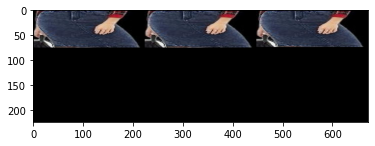

In [ ]:
plt.imshow(Show)

In [ ]:
Data1=Data1.transpose()
Data2=Data2.transpose()
Data3=Data3.transpose()
Data4=Data4.transpose()
Data5=Data5.transpose()
Data6=Data6.transpose()
Data7=Data7.transpose()
Datos3K=np.concatenate([Data1, Data2,Data3,Data4,Data5,Data6,Data7])

In [ ]:
Datos3K

array([[230, 179,  98, ..., 196, 143,  67],
       [  5,   0,   4, ...,   0,   1,   2],
       [  0,   0,   0, ...,   1,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

In [ ]:
print(Datos3K.shape)

(700, 451584)


In [ ]:
X =np.reshape(Datos3K,(Datos3K.shape[0],224,672,3))
X = X.astype('float32') / 255.
X.shape

(700, 224, 672, 3)

In [ ]:
print(X.shape)

(700, 224, 672, 3)


In [ ]:
Yvalues = []
for i in range(100): 
  Yvalues.append(i)
Yvalues= np.array(Yvalues)
Yvalues = np.concatenate([Yvalues, Yvalues,Yvalues,Yvalues,Yvalues,Yvalues,Yvalues])

In [ ]:
#Yvalues=Yvalues.reshape(50,1)
Yvalues.shape

(700,)

In [ ]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(Yvalues)

# Display the change for category label using one-hot encoding
print('Original label:', Yvalues[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 0
After conversion to one-hot: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
train_X,valid_X,train_label,valid_label = train_test_split(X,train_Y_one_hot,test_size=0.2)


In [ ]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(560, 224, 672, 3) (140, 224, 672, 3) (560, 100) (140, 100)


In [ ]:
num_classes=100
input_img = Input(shape=(224, 672, 3)) 
def encoder(input_img):
    #encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    return encoded

def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    den= Dropout(0.2)(den)
    den = Dense(80, activation='relu')(den)
    den= Dropout(0.2)(den)
    out = Dense(num_classes, activation='softmax')(den)
    return out

encode = encoder(input_img)
autoencoderClassifier = Model(input_img,fc(encode))

In [ ]:
for l1,l2 in zip(autoencoderClassifier.layers[:7],autoencoderClassifier.layers[0:7]):
    l1.set_weights(l2.get_weights())

In [ ]:
autoencoderClassifier.get_weights()[0][1];

In [ ]:
for layer in autoencoderClassifier.layers[0:7]:
    layer.trainable = False

In [ ]:
autoencoderClassifier.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(),metrics=['accuracy'])


In [ ]:
autoencoderClassifier.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 672, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 672, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 336, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 336, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 168, 32)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 301056)            0     

In [ ]:
classify_train = autoencoderClassifier.fit(train_X, train_label, batch_size=5,epochs=20,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/20
112/112 [==============================] - 77s 658ms/step - loss: 4.6146 - accuracy: 0.0036 - val_loss: 4.6164 - val_accuracy: 0.0071
Epoch 2/20
112/112 [==============================] - 74s 657ms/step - loss: 4.5910 - accuracy: 0.0232 - val_loss: 4.6324 - val_accuracy: 0.0000e+00
Epoch 3/20
112/112 [==============================] - 73s 652ms/step - loss: 4.5724 - accuracy: 0.0268 - val_loss: 4.6554 - val_accuracy: 0.0000e+00
Epoch 4/20
112/112 [==============================] - 74s 663ms/step - loss: 4.5379 - accuracy: 0.0482 - val_loss: 4.6849 - val_accuracy: 0.0000e+00
Epoch 5/20
112/112 [==============================] - 73s 655ms/step - loss: 4.5124 - accuracy: 0.0268 - val_loss: 4.6988 - val_accuracy: 0.0000e+00
Epoch 6/20
112/112 [==============================] - 73s 652ms/step - loss: 4.4832 - accuracy: 0.0625 - val_loss: 4.7065 - val_accuracy: 0.0000e+00
Epoch 7/20
112/112 [==============================] - 74s 659ms/step - loss: 4.4363 - accuracy: 0.0464 - val_l

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


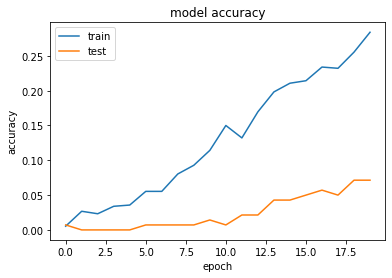

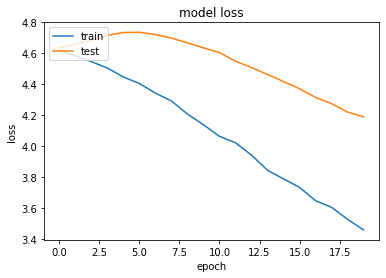

In [ ]:
print(classify_train.history.keys())
# summarize history for accuracy
plt.plot(classify_train.history['accuracy'])
plt.plot(classify_train.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(classify_train.history['loss'])
plt.plot(classify_train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_eval = autoencoderClassifier.evaluate(valid_X, valid_label, verbose=0)


In [ ]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 4.303954601287842
Test accuracy: 0.09285714477300644


In [ ]:
predicted_classes = autoencoderClassifier.predict(X)


22/22 [==============================] - 1s 34ms/step


In [ ]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)


In [ ]:
predicted_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
predicted_classes.shape, Yvalues.shape


((700,), (700,))

Found 693 incorrect labels


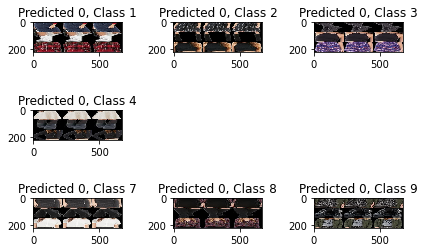

In [ ]:
incorrect = np.where(predicted_classes!=Yvalues)[0]
print ("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X[incorrect].reshape(224,672,3), interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], Yvalues[incorrect]))
    plt.tight_layout()

In [ ]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(Yvalues, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.01      1.00      0.02         7
     Class 1       0.00      0.00      0.00         7
     Class 2       0.00      0.00      0.00         7
     Class 3       0.00      0.00      0.00         7
     Class 4       0.00      0.00      0.00         7
     Class 5       0.00      0.00      0.00         7
     Class 6       0.00      0.00      0.00         7
     Class 7       0.00      0.00      0.00         7
     Class 8       0.00      0.00      0.00         7
     Class 9       0.00      0.00      0.00         7
    Class 10       0.00      0.00      0.00         7
    Class 11       0.00      0.00      0.00         7
    Class 12       0.00      0.00      0.00         7
    Class 13       0.00      0.00      0.00         7
    Class 14       0.00      0.00      0.00         7
    Class 15       0.00      0.00      0.00         7
    Class 16       0.00      0.00      0.00         7
    Class 17       0.00    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
autoencoderClassifier.save('EscenarioConvClassifier.h5')